## Install Packages

In [32]:
!pip install pandas matplotlib numpy seaborn

In [33]:
!pip install scikit-learn imbalanced-learn xgboost feature-engine

## Import Packages

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt, style as st
import zipfile
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_validate
)
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils._testing import ignore_warnings
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import (
    EditedNearestNeighbours,
    RandomUnderSampler,
    TomekLinks
)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [35]:
st.use('ggplot')

## Read data

## Data sources
### Credit Card Fraud Detection
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download&select=creditcard.csv

GitHub has limitation of size of file to upload and there is no direct link to data file to download it programmatically.
For these reasons this data file is not included in this repository.
To get this file it is necessary to click on "Download" button on link provided above, unzip downloaded file and move it into datasets folder of this project.
File name: creditcard.csv

### Diabetes prediction dataset
https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
This data file has small size and it is included in this repository.
File name: diabetes_prediction_dataset.csv

In [70]:
# Read data into Panda dataframe
diabetes_data = pd.read_csv("datasets/diabetes_prediction_dataset.csv")
card_data = pd.read_csv("datasets/creditcard.csv")

In [37]:
# Shuffle the DataFrame rows
diabetes_data = diabetes_data.sample(frac=1)

# Get a sample of 100000 records shuffled
card_data = card_data.sample(n=100000)

## Data Set Exploration

### Diabetes Data Set

In [38]:
diabetes_data.shape

(100000, 9)

In [39]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 58791 to 53090
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.6+ MB


In [40]:
diabetes_data["diabetes"].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [41]:
diabetes_data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [42]:
def get_columns_with_null(df):
    # Get the columns with null values
    return df.columns[df.isnull().any()]

columns_with_null = get_columns_with_null(diabetes_data)
print(f"Number of columns with null values: {len(columns_with_null)}")

Number of columns with null values: 0


In [43]:
diabetes_data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
58791,Male,43.0,0,0,former,28.68,6.6,159,0
67247,Female,32.0,0,0,never,27.32,6.5,200,0
5041,Male,47.0,0,0,not current,27.32,6.2,159,0
93217,Female,54.0,0,0,No Info,27.32,3.5,130,0
22321,Female,75.0,0,0,never,27.32,6.0,200,0


<Axes: xlabel='diabetes', ylabel='count'>

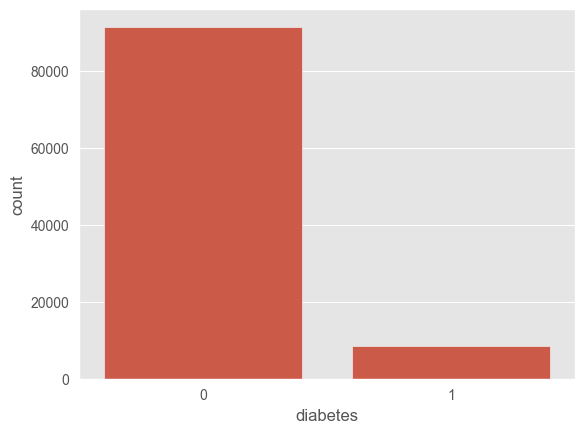

In [44]:
sns.countplot(data=diabetes_data, x='diabetes')

In [45]:
categorical_columns = [col for col in diabetes_data.columns if diabetes_data[col].dtype == 'object']
print(categorical_columns)

['gender', 'smoking_history']


In [46]:
diabetes_data[categorical_columns].nunique()

gender             3
smoking_history    6
dtype: int64

In [47]:
numeric_columns = [col for col in diabetes_data.columns if np.issubdtype(diabetes_data[col].dtype, np.number)]
print(numeric_columns)

['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


### Credit Card Data Set

In [48]:
card_data.shape

(100000, 31)

In [49]:
card_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 105069 to 14123
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    100000 non-null  float64
 1   V1      100000 non-null  float64
 2   V2      100000 non-null  float64
 3   V3      100000 non-null  float64
 4   V4      100000 non-null  float64
 5   V5      100000 non-null  float64
 6   V6      100000 non-null  float64
 7   V7      100000 non-null  float64
 8   V8      100000 non-null  float64
 9   V9      100000 non-null  float64
 10  V10     100000 non-null  float64
 11  V11     100000 non-null  float64
 12  V12     100000 non-null  float64
 13  V13     100000 non-null  float64
 14  V14     100000 non-null  float64
 15  V15     100000 non-null  float64
 16  V16     100000 non-null  float64
 17  V17     100000 non-null  float64
 18  V18     100000 non-null  float64
 19  V19     100000 non-null  float64
 20  V20     100000 non-null  float64
 21  V21     100

In [50]:
card_data["Class"].value_counts()

Class
0    99824
1      176
Name: count, dtype: int64

In [51]:
card_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,94764.788510,0.005180,0.001990,0.003438,0.004826,-0.000848,-0.003124,0.007677,0.000064,-0.004217,...,0.000693,-0.000396,-0.000608,0.001461,-0.001102,0.001086,-0.001040,0.001103,88.812533,0.001760
std,47425.941739,1.928989,1.627583,1.506011,1.412248,1.358995,1.321616,1.205409,1.162455,1.095986,...,0.717624,0.721510,0.621601,0.604561,0.520263,0.483480,0.395567,0.347368,246.008921,0.041916
min,2.000000,-56.407510,-72.715728,-33.680984,-5.560118,-42.147898,-26.160506,-41.506796,-73.216718,-13.434066,...,-34.830382,-8.887017,-44.807735,-2.824849,-10.295397,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,54235.750000,-0.924232,-0.592401,-0.887846,-0.842238,-0.690763,-0.767268,-0.547917,-0.210151,-0.648874,...,-0.227614,-0.542282,-0.162088,-0.352253,-0.317988,-0.327457,-0.071715,-0.052791,5.500000,0.000000
50%,84624.500000,0.013984,0.069268,0.179106,-0.016193,-0.053044,-0.277199,0.044087,0.021589,-0.052646,...,-0.028724,0.009094,-0.011652,0.041912,0.013079,-0.051524,0.000933,0.011288,22.000000,0.000000
75%,139111.750000,1.315619,0.805751,1.029865,0.748948,0.605584,0.391481,0.572704,0.327344,0.595240,...,0.186893,0.523429,0.146716,0.439710,0.350247,0.242411,0.090756,0.078117,77.550000,0.000000
max,172788.000000,2.420346,21.467203,9.382558,16.491217,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,10.503090,19.002942,4.022866,5.525093,3.517346,11.135740,33.847808,12910.930000,1.000000


In [52]:
card_columns_with_null = get_columns_with_null(card_data)
print(f"Number of columns with null values: {len(columns_with_null)}")

Number of columns with null values: 0


In [53]:
card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
105069,69351.0,1.093750,-0.250303,-0.069936,0.948742,0.387849,1.039074,-0.091543,0.147201,-0.948104,...,-0.209099,-0.687622,-0.143229,-1.156824,0.032637,3.072937,-0.234694,-0.033874,98.94,0
224597,143876.0,2.086384,-1.001051,-1.581097,-0.958046,-0.393204,-0.854413,-0.241025,-0.302324,-0.356967,...,-0.056847,-0.407910,0.140296,-0.805502,-0.177709,-0.383691,-0.052261,-0.050683,100.65,0
159087,112191.0,-2.226498,-1.745309,1.651711,-1.325129,2.041486,0.397615,-0.713758,0.671779,0.154239,...,0.435146,0.595298,0.283119,-0.283358,0.268061,1.416418,-0.119947,0.077366,115.00,0
217788,141036.0,1.874076,-0.368870,-0.290171,0.488194,-0.626189,-0.621531,-0.303391,-0.155051,1.069040,...,-0.126794,-0.258672,0.316849,-0.018528,-0.417626,-0.629251,0.037157,-0.019122,59.99,0
278105,168040.0,1.939096,-0.308436,-0.707139,1.232903,0.070089,0.706207,-0.484484,0.315589,1.134395,...,-0.532470,-1.371836,0.394723,-0.028406,-0.287751,-1.115665,0.036541,-0.041804,11.00,0


<Axes: xlabel='Class', ylabel='count'>

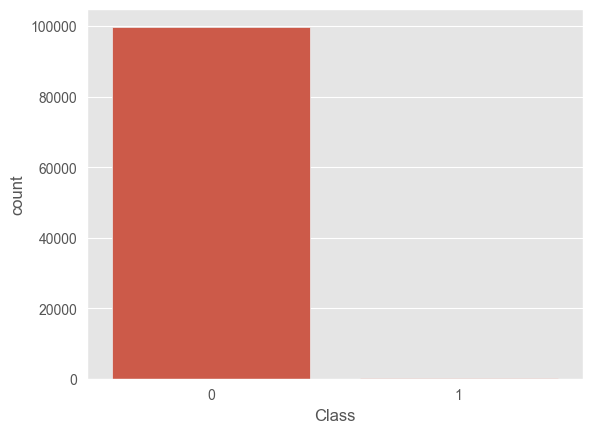

In [54]:
sns.countplot(data=card_data, x='Class')

In [55]:
categorical_columns = [col for col in card_data.columns if card_data[col].dtype == 'object']
print(categorical_columns)

[]


In [56]:
card_data[categorical_columns].nunique()

Series([], dtype: float64)

In [57]:
numeric_columns = [col for col in card_data.columns if np.issubdtype(card_data[col].dtype, np.number)]
print(numeric_columns)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## Add all datasets together

In [58]:
med_data = {}
med_data['DESCR'] = "diabetes_prediction_dataset"
med_data['target'] = diabetes_data['diabetes'].copy()
med_data['data'] = diabetes_data.drop(columns=['diabetes'])

credit_data = {}
credit_data['DESCR'] = "creditcard"
credit_data['target'] = card_data['Class'].copy()
credit_data['data'] = card_data.drop(columns=['Class'])

all_datasets = []
all_datasets.append(med_data)
all_datasets.append(credit_data)

In [59]:
# Set random set
random_state=42

## Define and run model

### Define model

In [60]:
@ignore_warnings(category=UserWarning)
def run_model(data, classifier, X_train, y_train, sampler=None):
    # Identify numerical and categorical features
    numeric_features = data['data'].select_dtypes(include=np.number).columns.tolist()
    categorical_features = data['data'].select_dtypes(include='object').columns.tolist()

    # Define preprocessing steps in a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create the pipeline with preprocessing and the classifier
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("sampler", sampler),
            ("model", classifier),
        ]
    )

    # Define scoring metrics
    scoring = {'average_precision': 'average_precision',
               'precision': make_scorer(precision_score, zero_division=0),
               'recall': make_scorer(recall_score, zero_division=0),
               'f1': make_scorer(f1_score, zero_division=0),
               'roc_auc': 'roc_auc'
               }

    # Run stratified cross-validation
    folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_state)
    cv_results = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=folds, n_jobs=-1
    )

    # Calculate mean of each score
    mean_scores = {f"mean_{metric}": cv_results[f"test_{metric}"].mean() for metric in scoring}

    print(
        "model: ",
        type(classifier).__name__
    )

    # Print average scores for each metric
    print(f"Mean Average precision: {mean_scores['mean_average_precision']:.3f}")
    print(f"Mean Precision: {mean_scores['mean_precision']:.3f}")
    print(f"Mean Recall: {mean_scores['mean_recall']:.3f}")
    print(f"Mean F1 score: {mean_scores['mean_f1']:.3f}")
    print(f"Mean ROC_AUC: {mean_scores['mean_roc_auc']:.3f}")
    print('----------------------------')

    return {**mean_scores}

### Define sampler map for over samplers, under samplers and hybrid samplers

In [61]:
sampler_map = {
    "Nosampling": None,
    "RandomOverSampler": RandomOverSampler(sampling_strategy="auto", random_state=random_state),
    "SMOTE": SMOTE(random_state=0),
    "RandomUnderSampler": RandomUnderSampler(
        sampling_strategy="auto", random_state=random_state, replacement=False
    ),
    "tomek": TomekLinks(sampling_strategy="auto", n_jobs=4),
    "enn": EditedNearestNeighbours(
        sampling_strategy="auto", n_neighbors=3, kind_sel="all", n_jobs=4
    ),
    "SMOTEENN": SMOTEENN(random_state=random_state),
    "SMOTETomek": SMOTETomek(random_state=random_state),
}

### Run models

In [62]:
pr_mean_dict_lr = {}
pr_mean_dict_rf = {}
pr_mean_dict_xgb = {}

for data in all_datasets:
    pr_mean_dict_lr[data["DESCR"]] = {}
    pr_mean_dict_rf[data["DESCR"]] = {}
    pr_mean_dict_xgb[data["DESCR"]] = {}

    for sampler in sampler_map.keys():
        print(sampler, " | Dataset description: ", data["DESCR"])
        # set up LogisticRegression classifier
        lr = LogisticRegression(random_state=random_state, max_iter=10000)
        aps_mean_lr = run_model(
            data, lr, data["data"], data["target"], sampler_map[sampler]
        )
        pr_mean_dict_lr[data["DESCR"]][sampler] = aps_mean_lr

        # set up the RandomForest classifier
        rf = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=3, n_jobs=4
        )
        aps_mean_rf = run_model(
            data, rf, data["data"], data["target"], sampler_map[sampler]
        )
        pr_mean_dict_rf[data["DESCR"]][sampler] = aps_mean_rf

        # set up the XGB classifier
        xgb = XGBClassifier()
        aps_mean_xgb = run_model(
            data, xgb, data["data"], data["target"], sampler_map[sampler]
        )
        pr_mean_dict_xgb[data["DESCR"]][sampler] = aps_mean_xgb

        print()
        print('=============================')

Nosampling  | Dataset description:  diabetes_prediction_dataset
model:  LogisticRegression
Mean Average precision: 0.817
Mean Precision: 0.873
Mean Recall: 0.623
Mean F1 score: 0.727
Mean ROC_AUC: 0.962
----------------------------
model:  RandomForestClassifier
Mean Average precision: 0.834
Mean Precision: 1.000
Mean Recall: 0.569
Mean F1 score: 0.725
Mean ROC_AUC: 0.950
----------------------------
model:  XGBClassifier
Mean Average precision: 0.880
Mean Precision: 0.957
Mean Recall: 0.693
Mean F1 score: 0.803
Mean ROC_AUC: 0.978
----------------------------

RandomOverSampler  | Dataset description:  diabetes_prediction_dataset
model:  LogisticRegression
Mean Average precision: 0.817
Mean Precision: 0.422
Mean Recall: 0.882
Mean F1 score: 0.571
Mean ROC_AUC: 0.962
----------------------------
model:  RandomForestClassifier
Mean Average precision: 0.853
Mean Precision: 0.508
Mean Recall: 0.869
Mean F1 score: 0.641
Mean ROC_AUC: 0.964
----------------------------
model:  XGBClassifier

## Show results

### Show results in table

In [63]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [64]:
def show_data_table(model_name, mean_dict):
    # Create a hierarchical index from the dictionary keys
    index = pd.MultiIndex.from_tuples([(k1, k2) for k1, v1 in mean_dict.items() for k2 in v1.keys()])

    # Extract values to form a Series
    values = pd.DataFrame([v2 for v1 in mean_dict.values() for v2 in v1.values()], index=index)

    # Create the DataFrame
    df = pd.DataFrame(values)

    # Rename the index levels for clarity
    df.index.names = ['Dataset', 'Sampling']

    print("\033[1m ", model_name)

    display(df)


In [65]:
show_data_table('Logistic Regression', pr_mean_dict_lr)
show_data_table('Random Forest', pr_mean_dict_rf)
show_data_table('XGBoost Classifier', pr_mean_dict_xgb)

  Logistic Regression


mean_average_precision  mean_precision  mean_recall   mean_f1  mean_roc_auc
Dataset                     Sampling                                                                                       
diabetes_prediction_dataset Nosampling                        0.817162        0.872826     0.623255  0.727163      0.961820
                            RandomOverSampler                 0.816594        0.422338     0.882000  0.571151      0.962168
                            SMOTE                             0.816553        0.422826     0.881765  0.571549      0.962140
                            RandomUnderSampler                0.816138        0.422746     0.881333  0.571384      0.962107
                            tomek                             0.817085        0.855778     0.635059  0.729017      0.961979
                            enn                               0.814512        0.771008     0.685137  0.725460      0.962099
                            SMOTEENN                          0.813562        0.393445     0.900706  0.547640      0.962007
                            SMOTETomek                        0.816443        0.422864     0.881686  0.571571      0.962141
creditcard                  Nosampling                        0.707354        0.839421     0.378730  0.517047      0.949844
                            RandomOverSampler                 0.726559        0.074772     0.879153  0.137729      0.962831
                            SMOTE                             0.711552        0.066864     0.871587  0.124097      0.962239
                            RandomUnderSampler                0.725635        0.538600     0.820423  0.642638      0.966445
                            tomek                             0.707233        0.844461     0.393757  0.531784      0.949729
                            enn                               0.706260        0.850104     0.426138  0.563648      0.949487
                            SMOTEENN                          0.712822        0.064867     0.873492  0.120674      0.962838
                            SMOTETomek                        0.710521        0.066851     0.869683  0.124068      0.962063

  Random Forest


mean_average_precision  mean_precision  mean_recall   mean_f1  mean_roc_auc
Dataset                     Sampling                                                                                       
diabetes_prediction_dataset Nosampling                        0.833947        1.000000     0.568980  0.725193      0.949909
                            RandomOverSampler                 0.852753        0.507583     0.869333  0.640896      0.964173
                            SMOTE                             0.839574        0.506419     0.854824  0.635908      0.958733
                            RandomUnderSampler                0.853382        0.521128     0.866078  0.650504      0.964199
                            tomek                             0.833601        1.000000     0.570196  0.726167      0.949826
                            enn                               0.832879        1.000000     0.577373  0.732005      0.949421
                            SMOTEENN                          0.815773        0.464513     0.882588  0.608517      0.959835
                            SMOTETomek                        0.839388        0.508795     0.854235  0.637624      0.958685
creditcard                  Nosampling                        0.767115        0.875198     0.609788  0.715535      0.938145
                            RandomOverSampler                 0.686795        0.221875     0.843228  0.348101      0.963295
                            SMOTE                             0.689150        0.201513     0.846984  0.323831      0.968706
                            RandomUnderSampler                0.698103        0.130550     0.854550  0.223795      0.964846
                            tomek                             0.767565        0.867151     0.600265  0.706392      0.938304
                            enn                               0.756679        0.849996     0.653439  0.735984      0.939717
                            SMOTEENN                          0.683270        0.195187     0.845079  0.315511      0.967753
                            SMOTETomek                        0.687514        0.197848     0.846984  0.319172      0.968731

  XGBoost Classifier


mean_average_precision  mean_precision  mean_recall   mean_f1  mean_roc_auc
Dataset                     Sampling                                                                                       
diabetes_prediction_dataset Nosampling                        0.879779        0.956596     0.692706  0.803461      0.977638
                            RandomOverSampler                 0.875575        0.521919     0.878784  0.654842      0.976386
                            SMOTE                             0.876034        0.898864     0.712275  0.794678      0.976671
                            RandomUnderSampler                0.875025        0.459918     0.913922  0.611866      0.976607
                            tomek                             0.879871        0.931916     0.703843  0.801902      0.977663
                            enn                               0.882208        0.795044     0.763490  0.778841      0.978108
                            SMOTEENN                          0.879561        0.659191     0.821569  0.731382      0.977093
                            SMOTETomek                        0.876491        0.883722     0.719176  0.792902      0.976811
creditcard                  Nosampling                        0.807385        0.917039     0.748360  0.822583      0.967600
                            RandomOverSampler                 0.794512        0.864516     0.772963  0.814403      0.965602
                            SMOTE                             0.796139        0.756461     0.793862  0.771339      0.969202
                            RandomUnderSampler                0.679856        0.037237     0.890529  0.071225      0.960290
                            tomek                             0.805082        0.911186     0.746561  0.819145      0.966356
                            enn                               0.791392        0.871979     0.773069  0.816842      0.970635
                            SMOTEENN                          0.794659        0.663838     0.795767  0.720214      0.970195
                            SMOTETomek                        0.799601        0.743728     0.797672  0.766452      0.965633

### Show results for mean_recall as bar charts

In [66]:
def plot_recall(dataset, model_name, mean_dict):
    pr_mean_s = pd.Series(mean_dict[dataset["DESCR"]])

    # Extract mean_recall values and sampling methods
    sampling_methods = list(pr_mean_s.keys())
    mean_recall_values = [pr_mean_s[method]['mean_recall'] for method in sampling_methods]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(sampling_methods, mean_recall_values, color='skyblue')
    plt.xlabel('Sampling Method', fontsize=12)
    plt.ylabel('Mean Recall', fontsize=12)
    plt.title(f"Mean Recall for {model_name} on {dataset['DESCR']} data", fontsize=14)
    plt.xticks(rotation=45, ha="right")  # Rotate x labels for readability
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    # Show the plot
    plt.show()

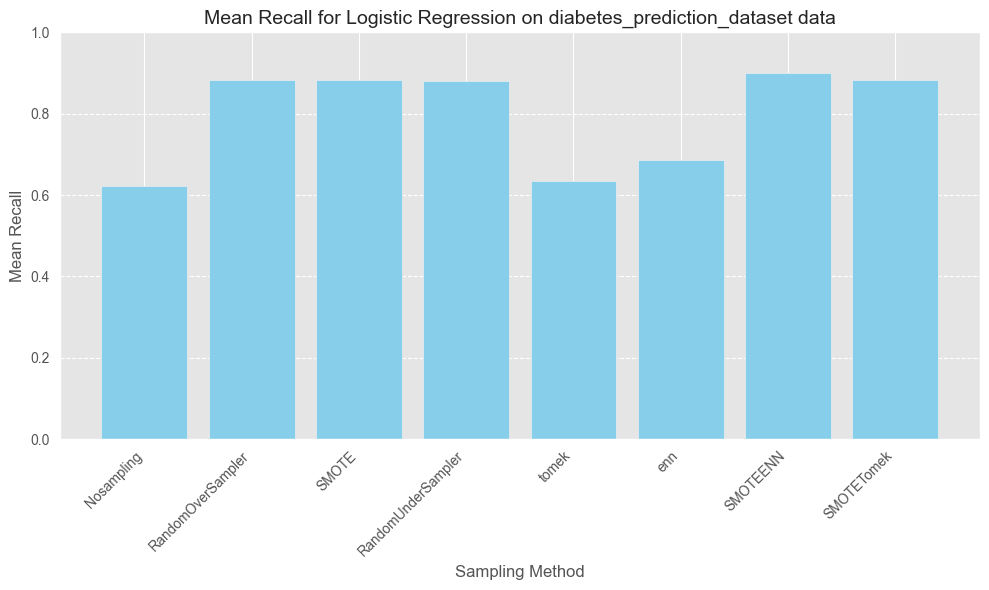

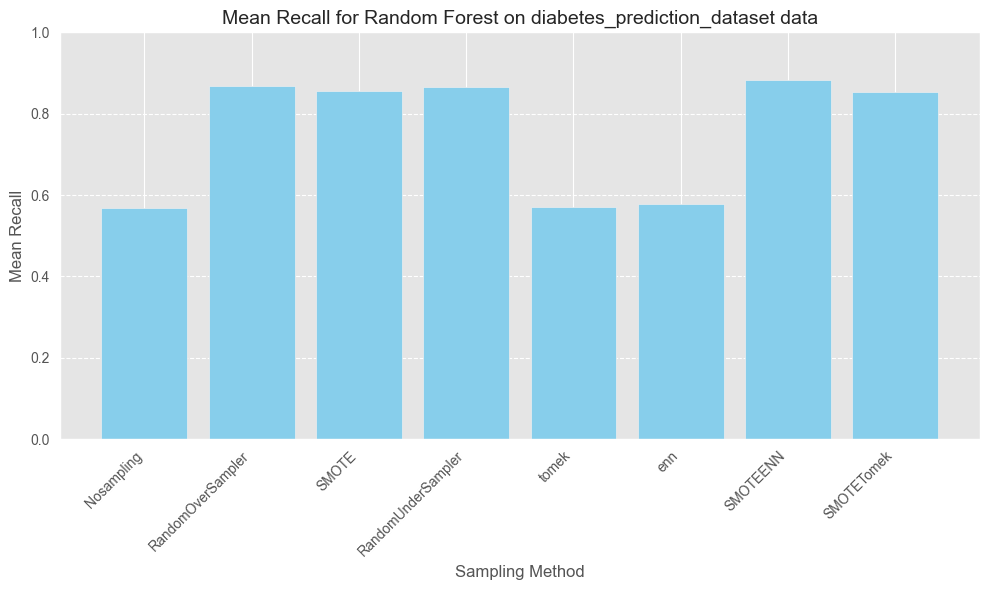

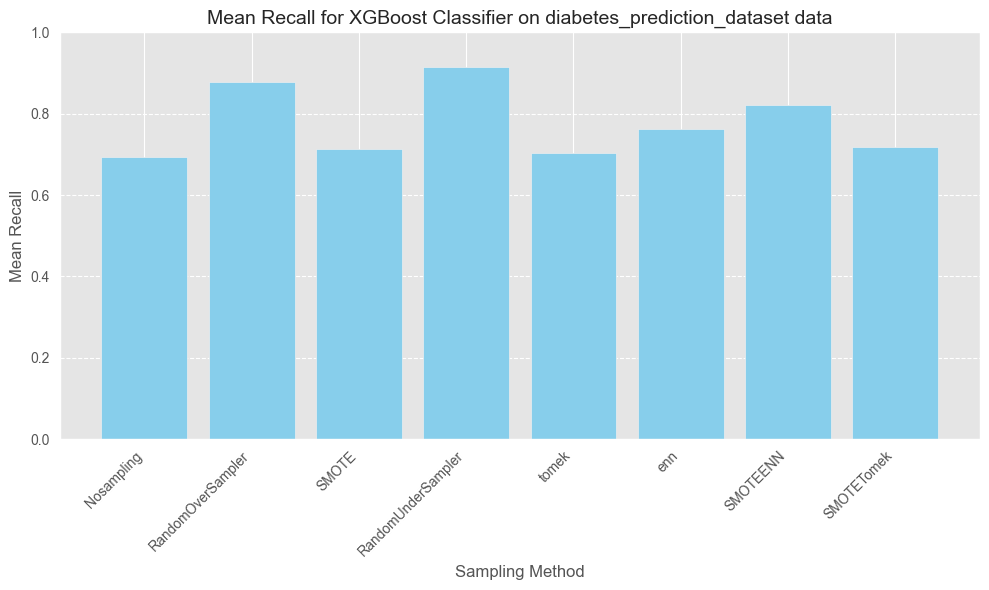

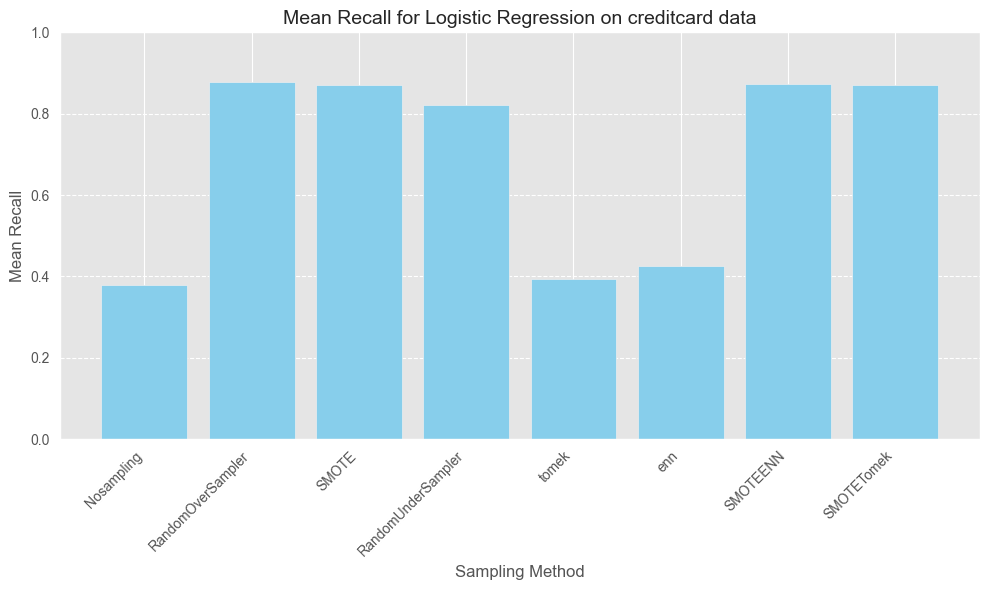

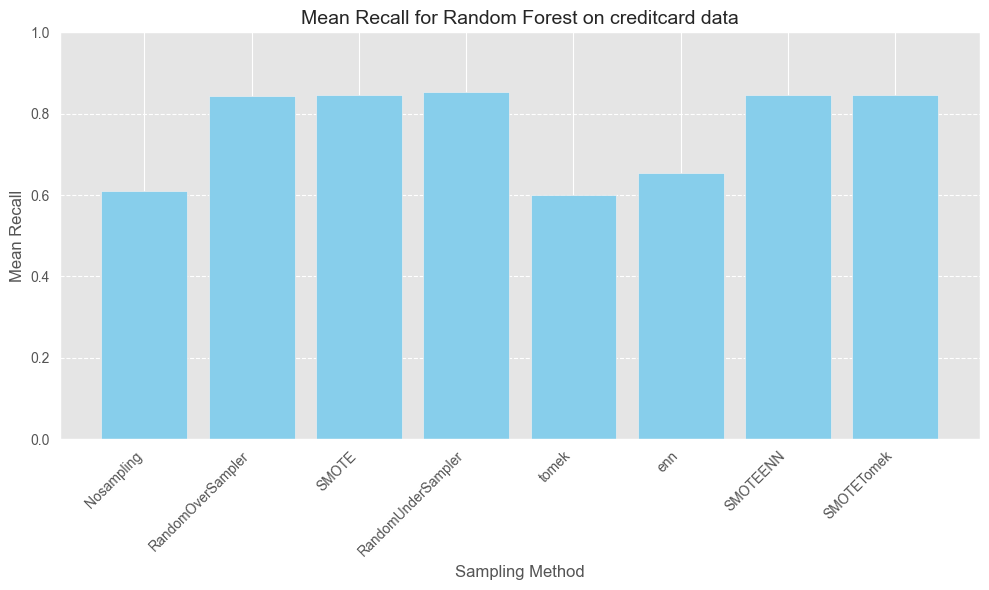

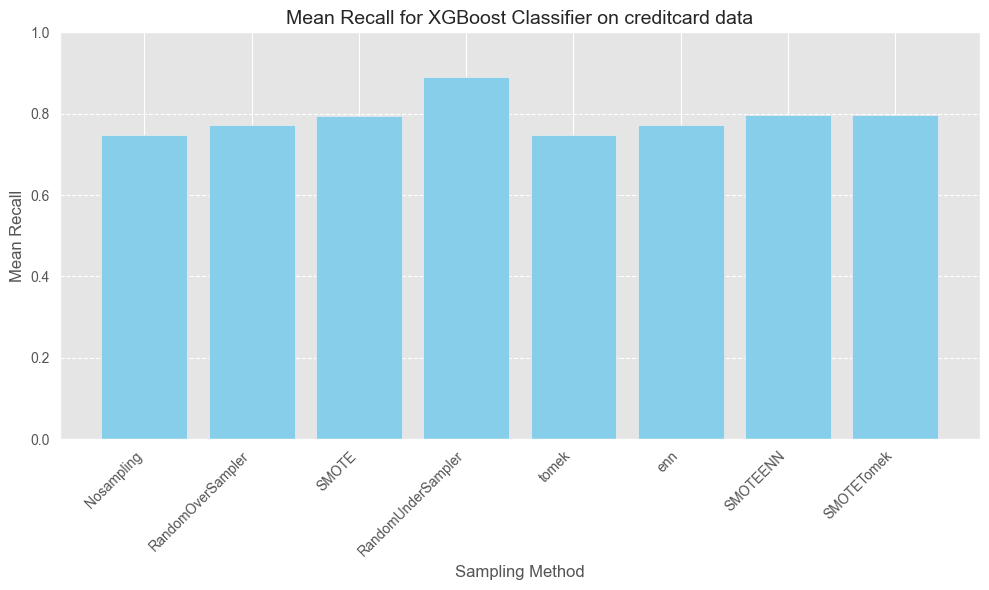

In [67]:
for dataset in all_datasets:
    plot_recall(dataset, 'Logistic Regression', pr_mean_dict_lr)
    plot_recall(dataset, 'Random Forest', pr_mean_dict_rf)
    plot_recall(dataset, 'XGBoost Classifier', pr_mean_dict_xgb)